In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
sns.set_style('darkgrid')

In [3]:
import warnings
warnings.filterwarnings("ignore") #Ignore warnings, mainly neural network convergence warning

## Defining constants 
Defining random state and path constants so that they can easily be updated when running on a diffrent system or the path changes. 

In [4]:
X_TRAIN = '../input/itk2020/x_train.csv'
Y_TRAIN = '../input/itk2020/y_train.csv'
X_TEST = '../input/itk2020/x_test.csv'
random_state = 42

## Data loading
Load training and test data to global variables to make them accessible throughout the notebook<br>
**<font color='red'>NB:</font> The classes are mapped to 0-6 by subructing an offset of one for training.**
**One is added to all predictions when saving to file to get original class labels**

In [5]:
def load_data():
    global dfx, dfy, df_test, test_idx
    dfx = pd.read_csv(X_TRAIN)
    dfy = pd.read_csv(Y_TRAIN)
    
    # remove the id column, it has no relevance for classification
    dfx = dfx.drop('id', axis=1)

    # remove id from cover type and make class values from 0-6 instead of 1-7
    dfy = dfy.drop('id', axis=1)
    dfy['Cover_Type'] = dfy['Cover_Type'].values-1
    
    #load test data and put indices on separate variable
    df_test = pd.read_csv(X_TEST)
    test_idx = df_test[['id']].copy()
    df_test = df_test.drop('id', axis=1)
    print('[Success] Training and test data loaded')

In [6]:
load_data()

[Success] Training and test data loaded


## Exploratory Data Analysis (EDA)

In [7]:
#NB: index column was dropped when loading data with load_data function
print(f'There are: {len(dfx.columns)} columns.')
print(f'Name of columns: {dfx.columns}')

There are: 54 columns.
Name of columns: Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_1',
       'Wilderness_Area_2', 'Wilderness_Area_3', 'Wilderness_Area_4',
       'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4',
       'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8',
       'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12',
       'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16',
       'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20',
       'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24',
       'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28',
       'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32',
       'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35', 

In [8]:
# separate lists for categorical and numerical attributes
num_cols = ['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points']
cat_cols = [x for x in dfx.columns if x not in num_cols]

In [9]:
#check if variable datatypes mactch attribute type
dfx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406708 entries, 0 to 406707
Data columns (total 54 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           406708 non-null  int64
 1   Aspect                              406708 non-null  int64
 2   Slope                               406708 non-null  int64
 3   Horizontal_Distance_To_Hydrology    406708 non-null  int64
 4   Vertical_Distance_To_Hydrology      406708 non-null  int64
 5   Horizontal_Distance_To_Roadways     406708 non-null  int64
 6   Hillshade_9am                       406708 non-null  int64
 7   Hillshade_Noon                      406708 non-null  int64
 8   Hillshade_3pm                       406708 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  406708 non-null  int64
 10  Wilderness_Area_1                   406708 non-null  int64
 11  Wilderness_Area_2                   406708 non-null 

In [10]:
#checking if all one hot encoded attributes are boolean(have values of either zero or one)
dfx.columns[dfx.isin([0,1]).all()]

Index(['Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3',
       'Wilderness_Area_4', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3',
       'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7',
       'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11',
       'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15',
       'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19',
       'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23',
       'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27',
       'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31',
       'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35',
       'Soil_Type_36', 'Soil_Type_37', 'Soil_Type_38', 'Soil_Type_39',
       'Soil_Type_40'],
      dtype='object')

Number of instances belonging to
	class 0:  148288(36.46%)
	class 1:  198310(48.76%)
	class 2:  25028(6.15%)
	class 3:  1923(0.47%)
	class 4:  6645(1.63%)
	class 5:  12157(2.99%)
	class 6:  14357(3.53%)


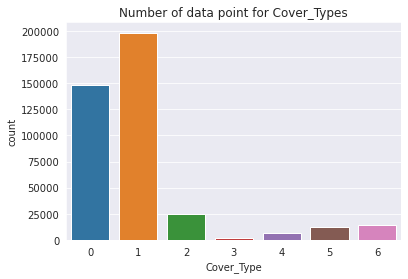

In [11]:
# Checking for class imbalance
print('Number of instances belonging to')
instances = len(dfy)
for i in range(7):
    cnt = dfy[dfy['Cover_Type'] == i]['Cover_Type'].count()
    print(f"\tclass {i}:  {cnt}({100*cnt/instances:.2f}%)")
sns.countplot(data = dfy, x='Cover_Type').set_title("Number of data point for Cover_Types");

In [12]:
print('Number of instances with ')
instances = len(dfy)
for attr in cat_cols[:4]:
    cnt = dfx[dfx[attr] == 1][attr].count()
    print(f"\t{attr}:  {cnt}({100*cnt/instances:.2f}%)")
    
count = []
for attr in cat_cols[4:]:
    cnt = dfx[dfx[attr] == 1][attr].count()
    count.append(cnt)
    
# Instance count with soil type in descending order
print('\nNumber of instances with ')
for i in np.argsort(count)[::-1]:
    print(f"\tSoil_Type_{i+1}:  {count[i]}({100*count[i]/instances:.4f}%)")

Number of instances with 
	Wilderness_Area_1:  182646(44.91%)
	Wilderness_Area_2:  20979(5.16%)
	Wilderness_Area_3:  177209(43.57%)
	Wilderness_Area_4:  25874(6.36%)

Number of instances with 
	Soil_Type_29:  80583(19.8135%)
	Soil_Type_23:  40514(9.9614%)
	Soil_Type_32:  36759(9.0382%)
	Soil_Type_33:  31507(7.7468%)
	Soil_Type_22:  23266(5.7206%)
	Soil_Type_10:  22805(5.6072%)
	Soil_Type_30:  21224(5.2185%)
	Soil_Type_12:  20900(5.1388%)
	Soil_Type_31:  18019(4.4305%)
	Soil_Type_24:  14811(3.6417%)
	Soil_Type_13:  12226(3.0061%)
	Soil_Type_38:  10951(2.6926%)
	Soil_Type_39:  9653(2.3734%)
	Soil_Type_4:  8732(2.1470%)
	Soil_Type_11:  8616(2.1185%)
	Soil_Type_20:  6463(1.5891%)
	Soil_Type_40:  6157(1.5139%)
	Soil_Type_2:  5284(1.2992%)
	Soil_Type_6:  4633(1.1391%)
	Soil_Type_3:  3370(0.8286%)
	Soil_Type_19:  2857(0.7025%)
	Soil_Type_17:  2402(0.5906%)
	Soil_Type_1:  2113(0.5195%)
	Soil_Type_16:  2001(0.4920%)
	Soil_Type_26:  1805(0.4438%)
	Soil_Type_18:  1367(0.3361%)
	Soil_Type_35:  131

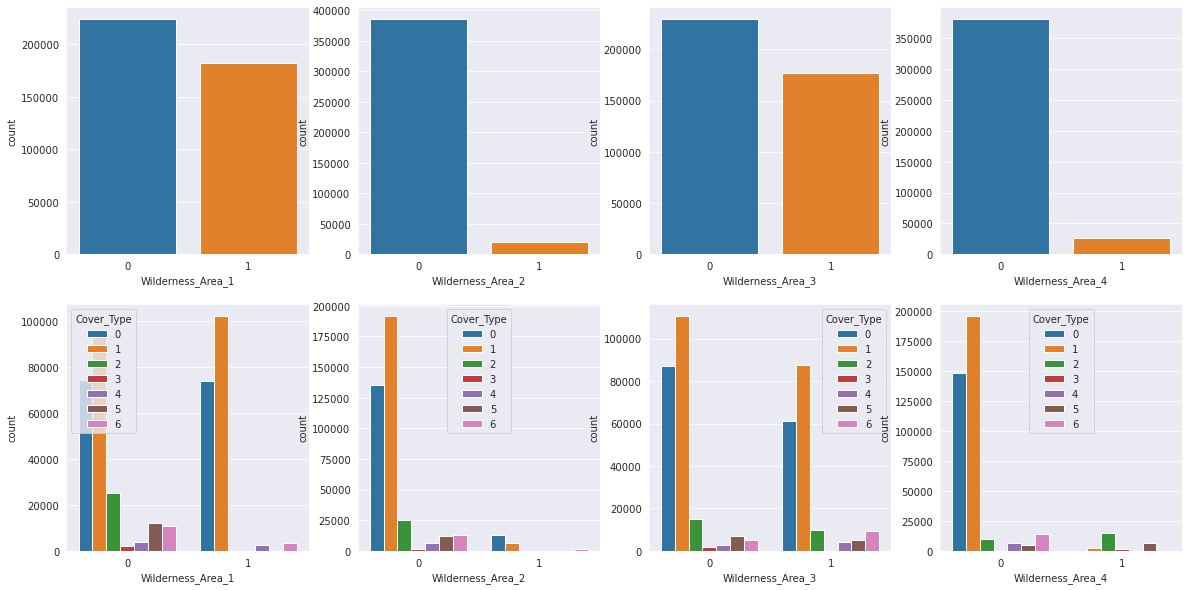

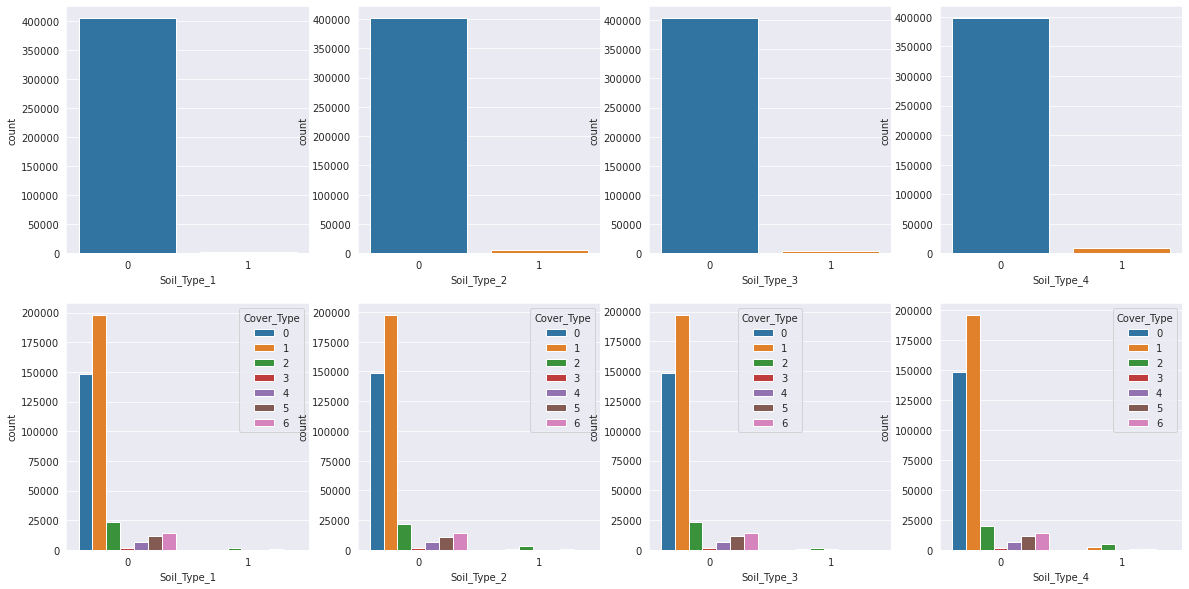

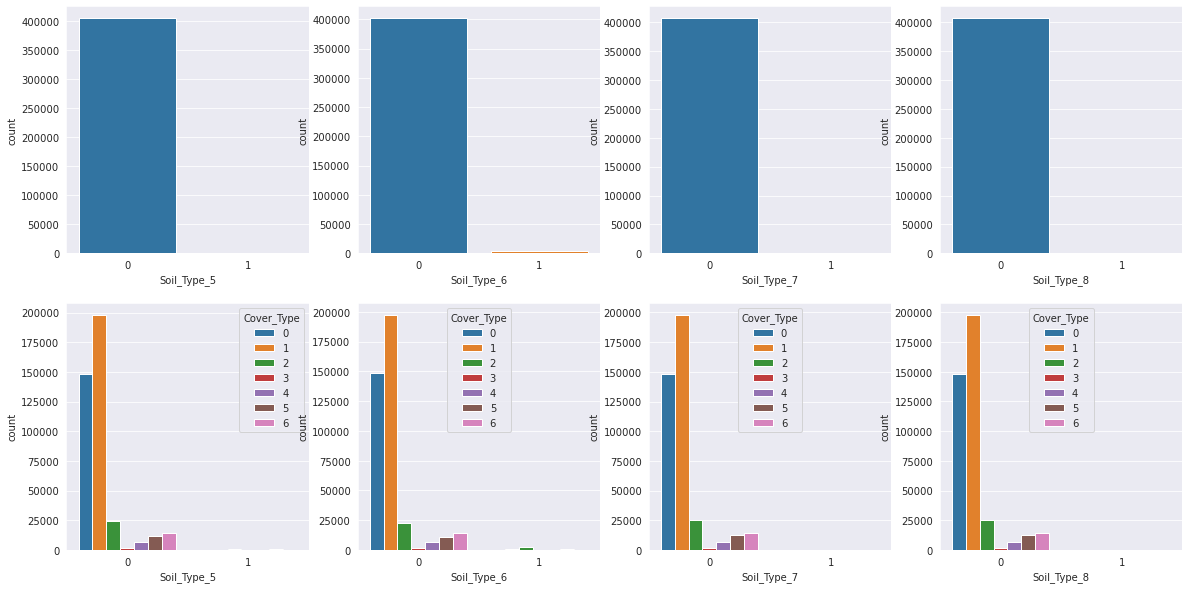

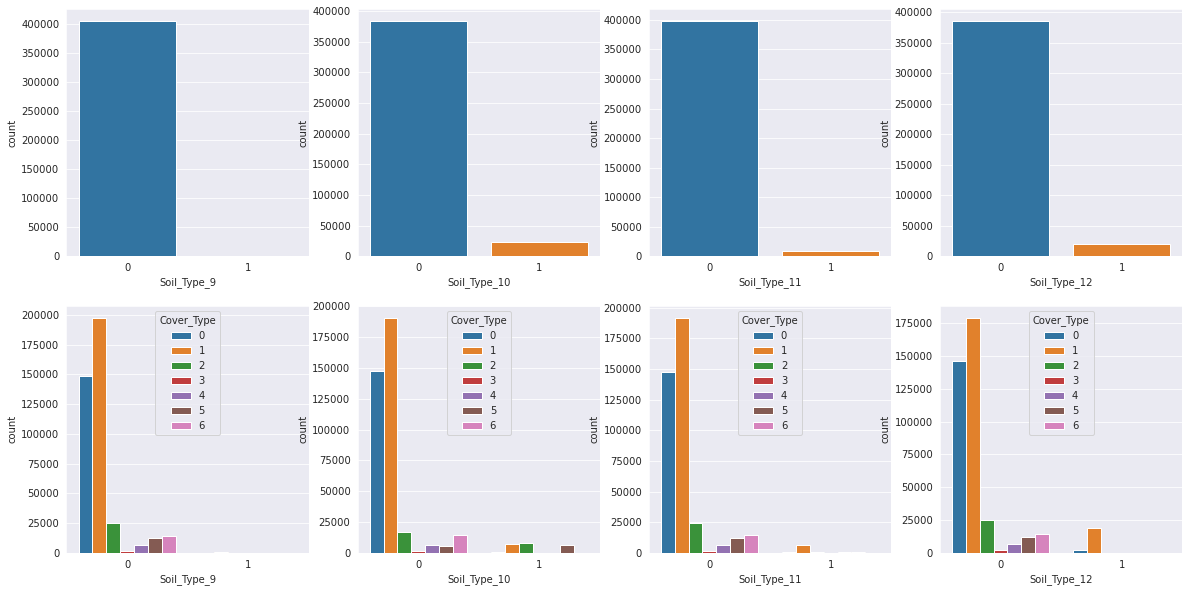

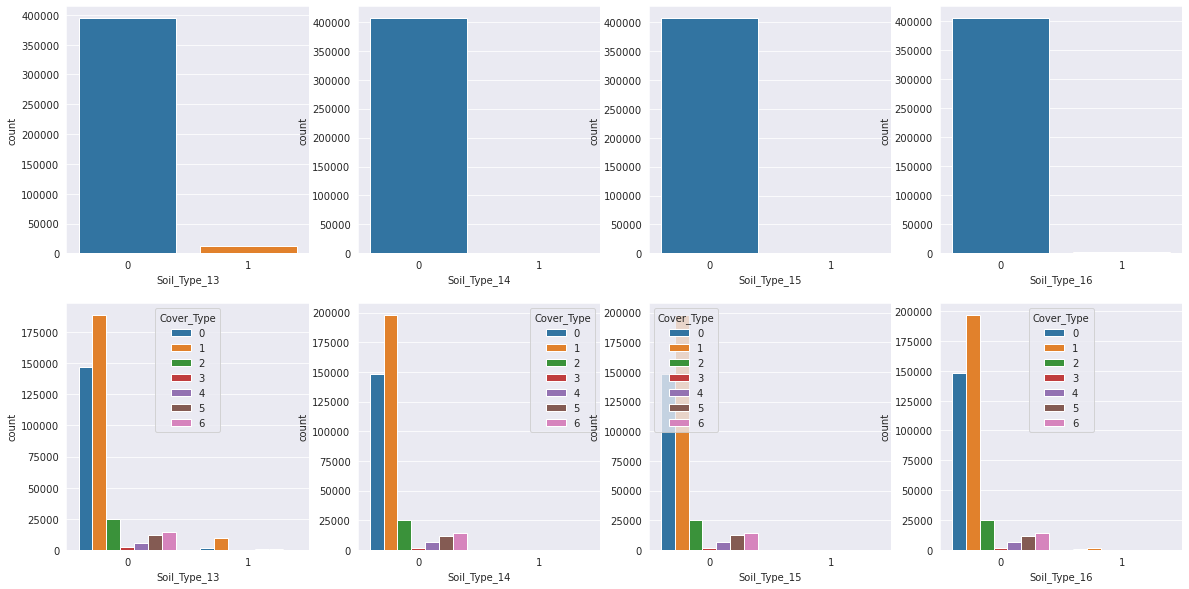

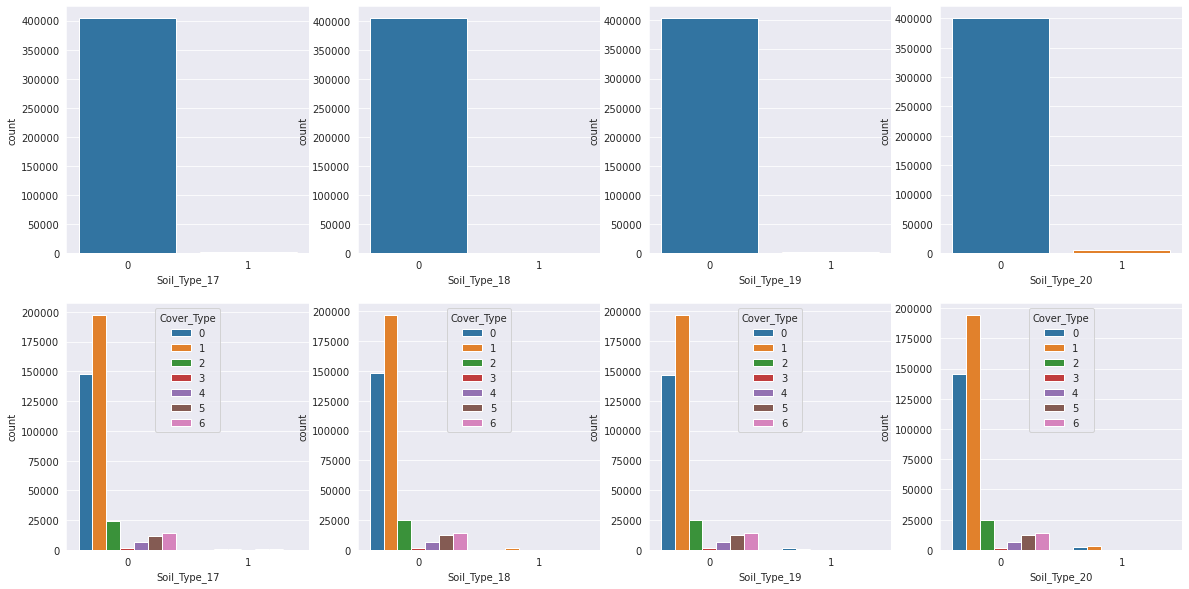

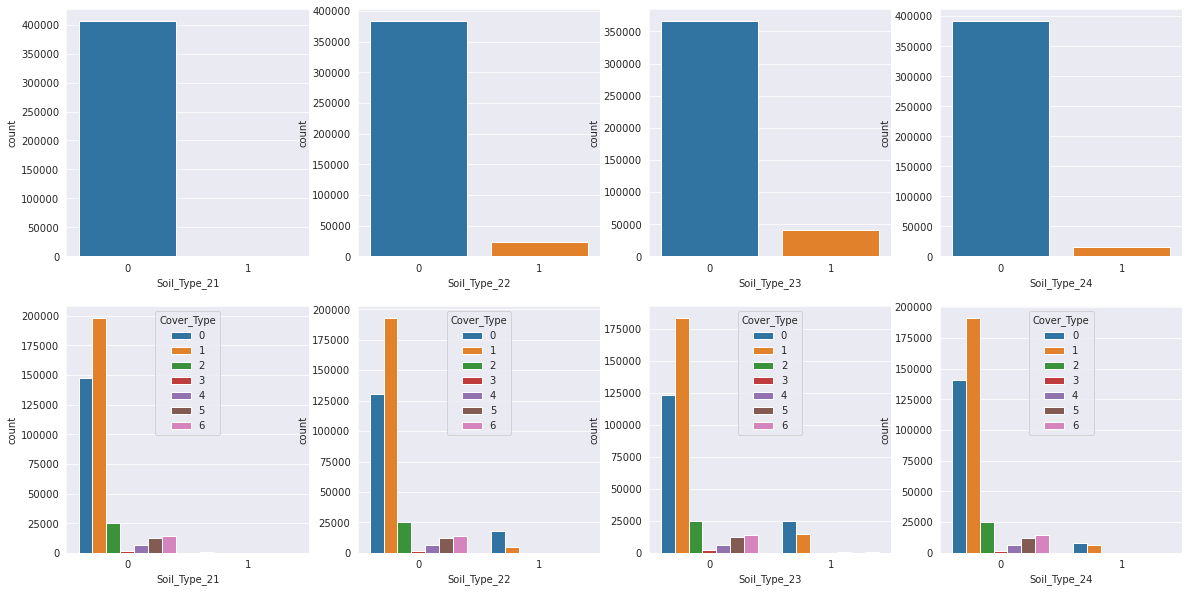

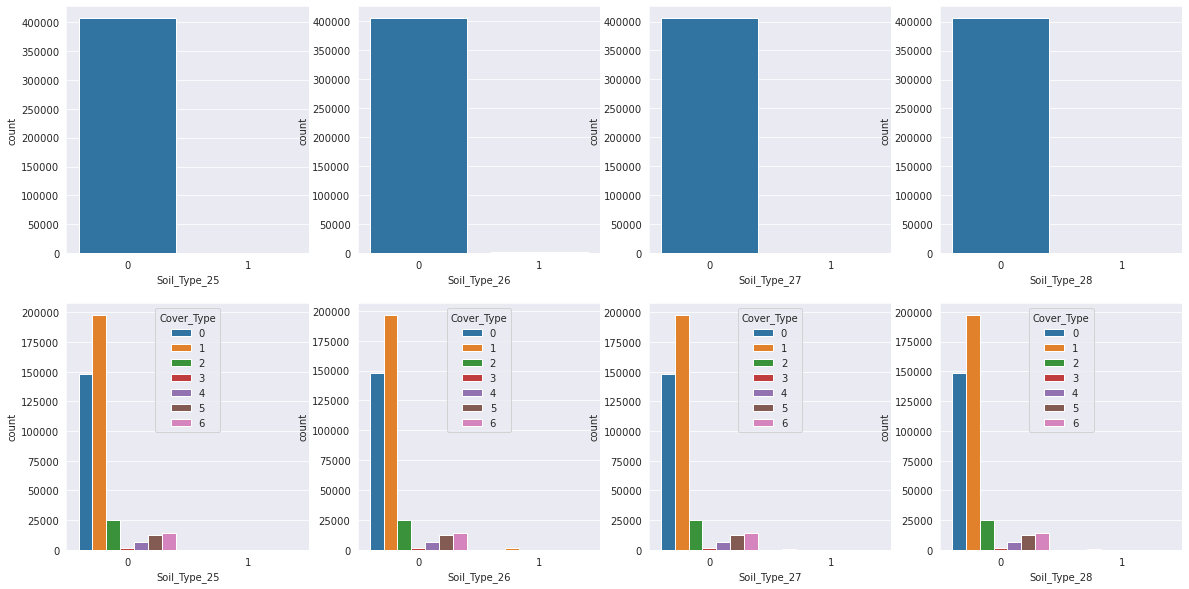

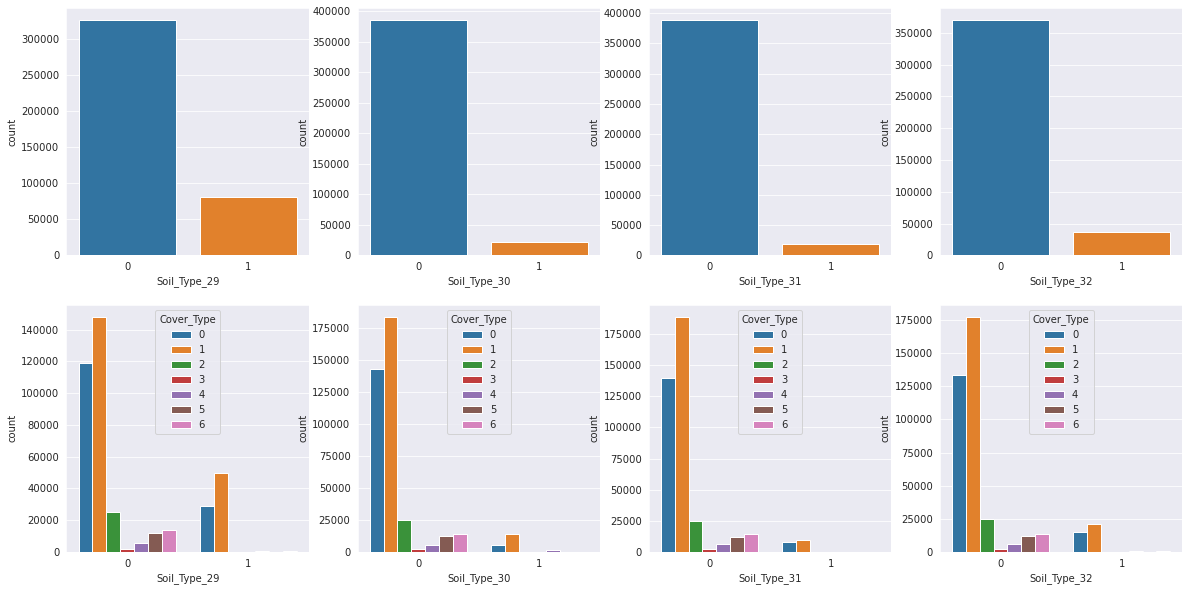

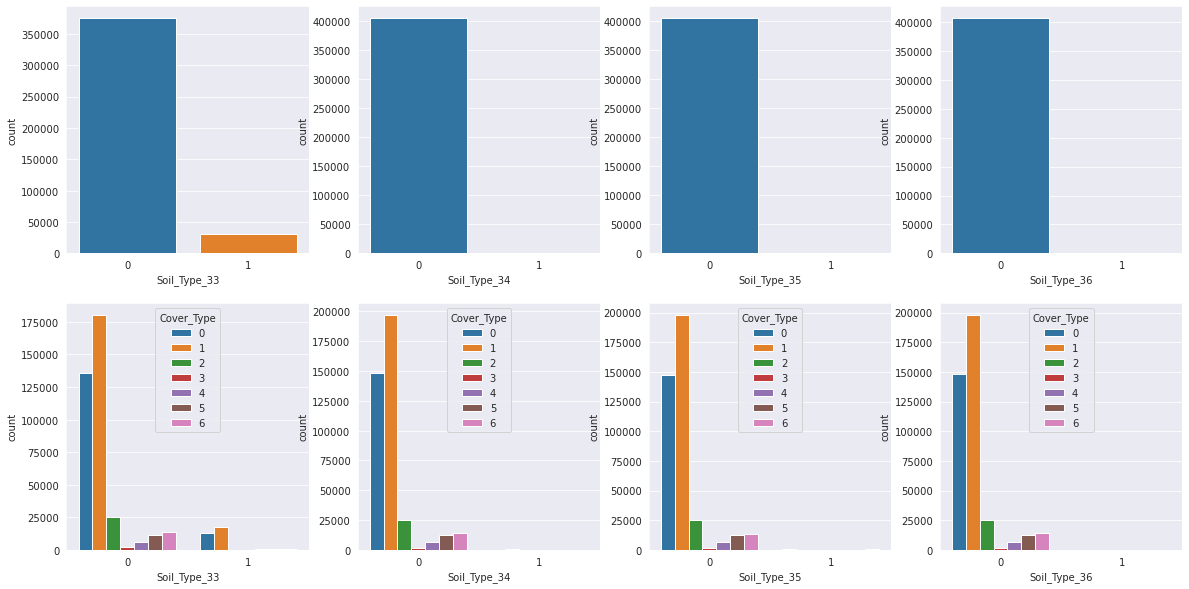

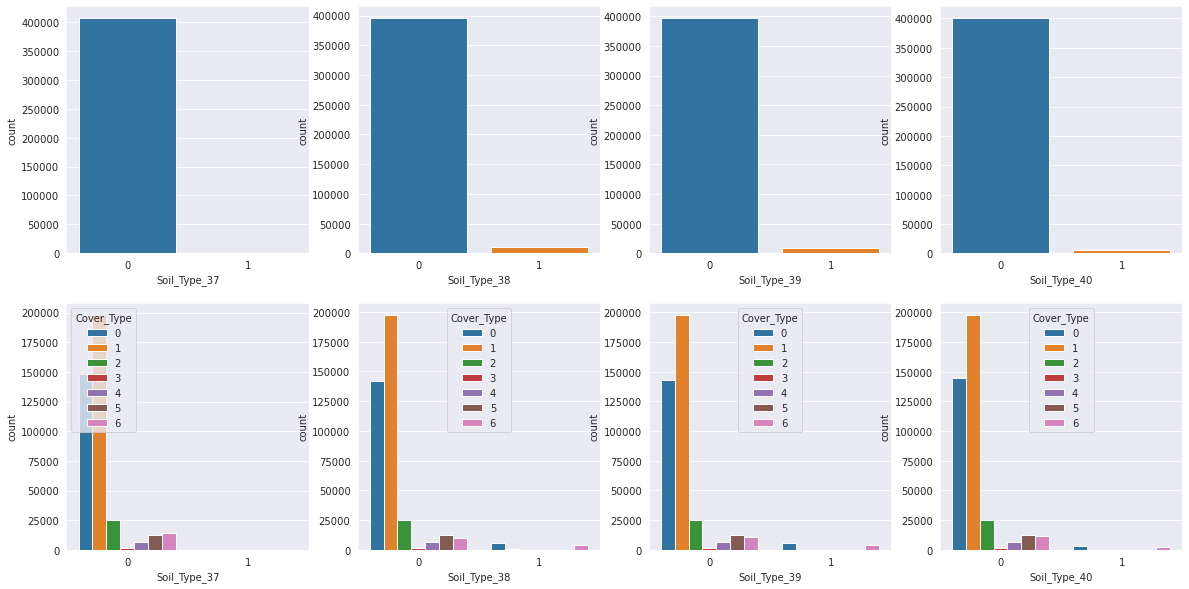

<Figure size 1440x720 with 0 Axes>

In [13]:
pcols = 4
prows = 2
i = 1
fig = plt.figure(figsize = (5*pcols,5*prows))
for col in cat_cols:
    if i<pcols+1:        
        sns.countplot(x=dfx[col], ax=fig.add_subplot(prows,pcols,i))
        sns.countplot(x=dfx[col],hue=dfy['Cover_Type'], ax=fig.add_subplot(prows,pcols,i+pcols))
        #sns.boxplot(x=dfx[col], y=dfy['Cover_Type'], ax=fig.add_subplot(prows,pcols,i+pcols))
    i += 1
    if i == pcols+1: 
        fig = plt.figure(figsize = (5*pcols,5*prows))
        i =1

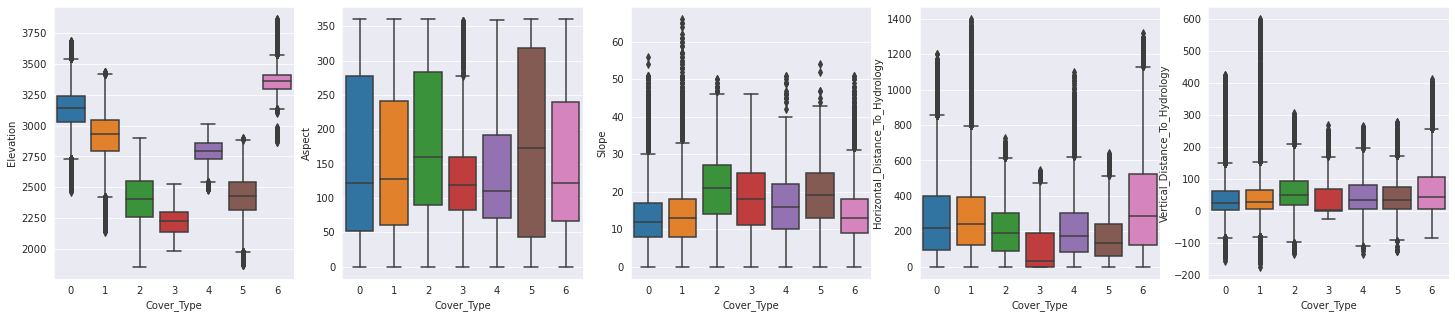

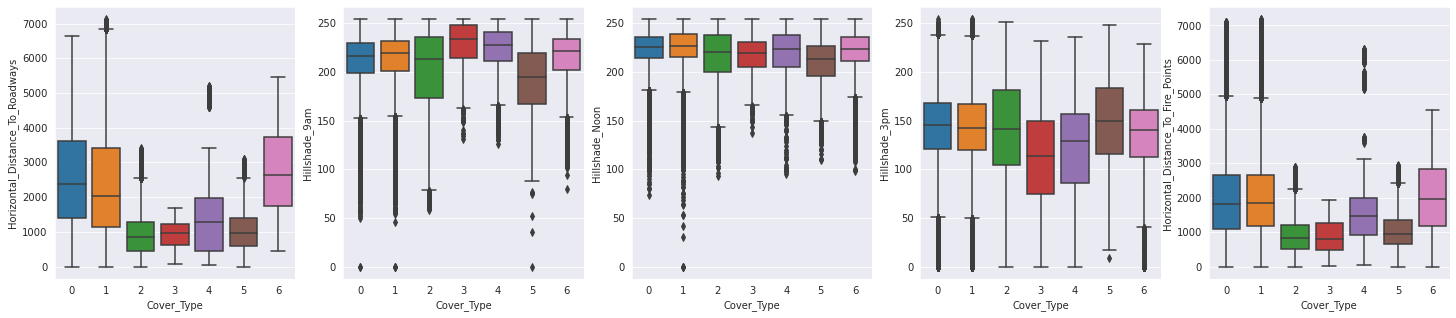

<Figure size 1800x360 with 0 Axes>

In [14]:
prows = 1
pcols = 5
fig = plt.figure(figsize = (5*pcols,5*prows))
i = 1
for col in num_cols[:10]:
    if i<pcols+1:
        sns.boxplot(x=dfy['Cover_Type'], y=dfx[col], ax=fig.add_subplot(prows,pcols,i))
    i += 1
    if i == pcols+1: 
        fig = plt.figure(figsize = (5*pcols,5*prows))
        i =1

In [15]:
# describing statistical characterstics of the numerical attributes
dfx[num_cols].describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
count,406708.000000,406708.000000,406708.000000,406708.000000,406708.000000,406708.000000,406708.000000,406708.000000,406708.000000,406708.000000
mean,2959.329730,155.763309,14.103413,269.485181,46.467994,2349.097488,212.107827,223.335543,142.593190,1979.708533
std,280.028028,111.925462,7.490411,212.462577,58.327213,1559.559608,26.785128,19.777075,38.269583,1323.353986
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1103.000000,198.000000,213.000000,119.000000,1024.000000
50%,2995.000000,127.000000,13.000000,218.000000,30.000000,1994.000000,218.000000,226.000000,143.000000,1710.000000
75%,3163.000000,261.000000,18.000000,390.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000
max,3858.000000,360.000000,66.000000,1397.000000,599.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000


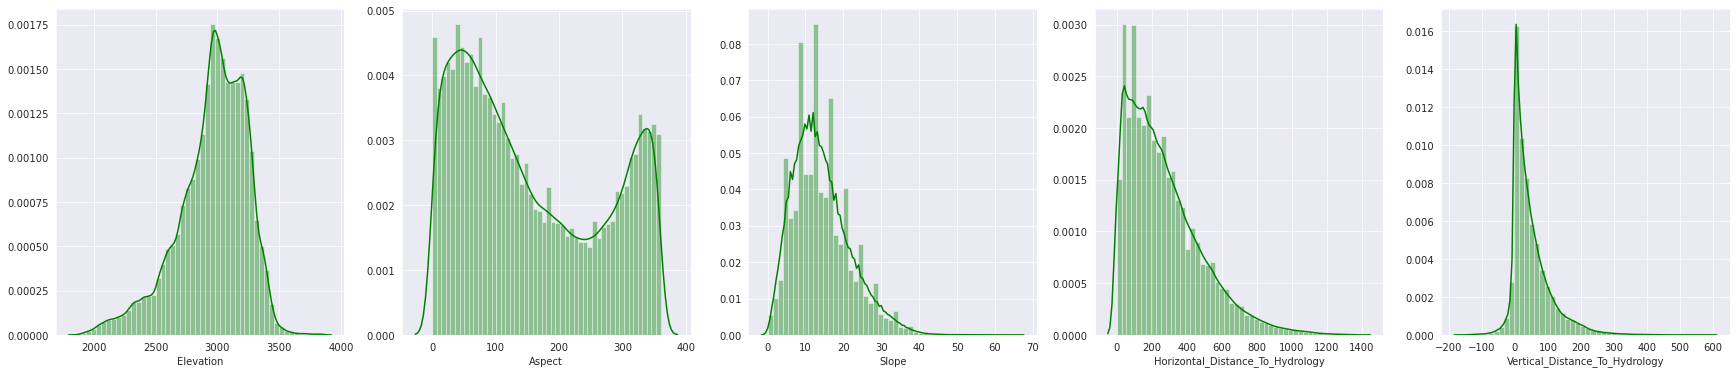

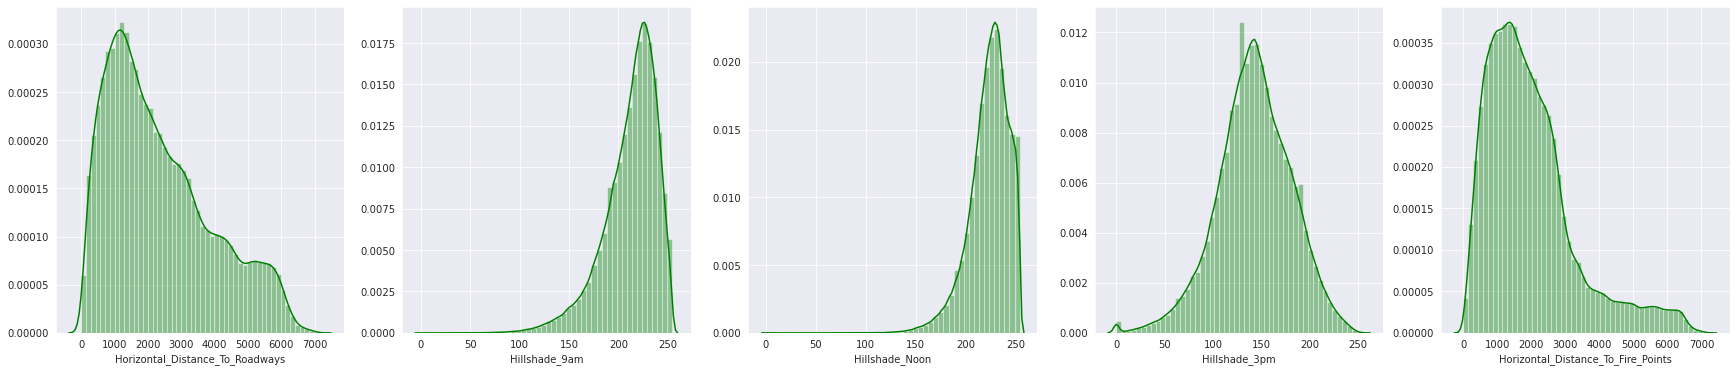

<Figure size 2160x432 with 0 Axes>

In [16]:
#dfx[num_cols].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);
prows = 1
pcols = 5
fig = plt.figure(figsize = (6*pcols,6*prows))
i = 1
for col in num_cols:
    if i<pcols+1:
        sns.distplot(dfx[col], color='g', bins=50,ax=fig.add_subplot(prows,pcols,i))
        #sns.boxplot(x=dfx[col], y=dfy['Cover_Type'], ax=fig.add_subplot(prows,pcols,i+pcols))
    i += 1
    if i == pcols+1: 
        fig = plt.figure(figsize = (6*pcols,6*prows))
        i =1

In [17]:
dfx_corr = dfx[num_cols].corr()
dfx_corr

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
Elevation,1.000000,0.015588,-0.242000,0.306433,0.093212,0.365704,0.112140,0.204632,0.058521,0.148610
Aspect,0.015588,1.000000,0.079768,0.018024,0.070695,0.025227,-0.579636,0.335226,0.647047,-0.109745
Slope,-0.242000,0.079768,1.000000,-0.009577,0.275731,-0.216650,-0.328841,-0.526525,-0.174189,-0.185942
Horizontal_Distance_To_Hydrology,0.306433,0.018024,-0.009577,1.000000,0.605947,0.070783,-0.026560,0.046525,0.051625,0.052232
Vertical_Distance_To_Hydrology,0.093212,0.070695,0.275731,0.605947,1.000000,-0.046750,-0.165438,-0.110944,0.034052,-0.068951
Horizontal_Distance_To_Roadways,0.365704,0.025227,-0.216650,0.070783,-0.046750,1.000000,0.035092,0.189554,0.105790,0.332074
Hillshade_9am,0.112140,-0.579636,-0.328841,-0.026560,-0.165438,0.035092,1.000000,0.010752,-0.780289,0.133206
Hillshade_Noon,0.204632,0.335226,-0.526525,0.046525,-0.110944,0.189554,0.010752,1.000000,0.593942,0.056708
Hillshade_3pm,0.058521,0.647047,-0.174189,0.051625,0.034052,0.105790,-0.780289,0.593942,1.000000,-0.048639
Horizontal_Distance_To_Fire_Points,0.148610,-0.109745,-0.185942,0.052232,-0.068951,0.332074,0.133206,0.056708,-0.048639,1.000000


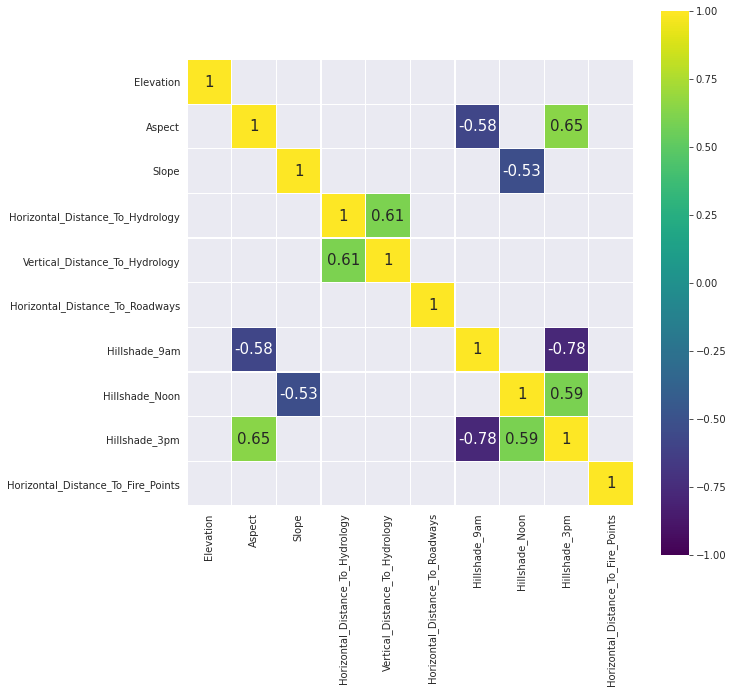

In [18]:
fig, ax = plt.subplots(figsize=(10,10))  
dfx_corr[abs(dfx_corr)>0.5]
sns.heatmap(dfx_corr[abs(dfx_corr)>0.5],cmap='viridis', vmax=1.0, vmin=-1.0, 
            linewidths=0.2,annot=True, annot_kws={"size": 15}, square=True, ax=ax)

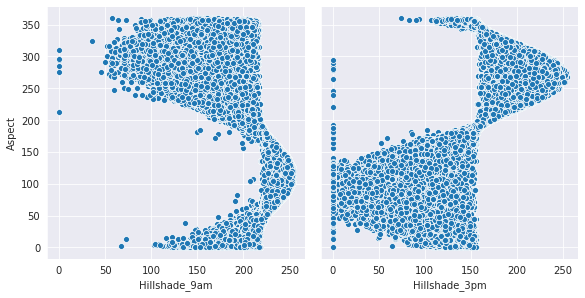

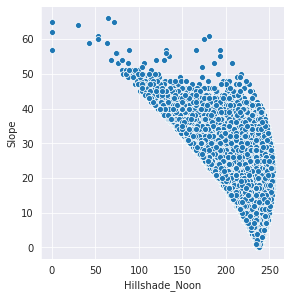

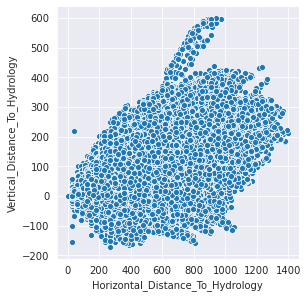

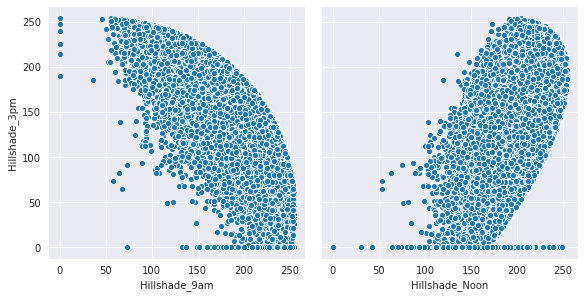

In [19]:
height=4
sns.pairplot(dfx, x_vars=['Hillshade_9am','Hillshade_3pm'], y_vars=['Aspect'], height=height)
sns.pairplot(dfx, x_vars=['Hillshade_Noon'], y_vars=['Slope'], height=height)
sns.pairplot(dfx, x_vars=['Horizontal_Distance_To_Hydrology'], y_vars=['Vertical_Distance_To_Hydrology'], height=height)
sns.pairplot(dfx, x_vars=['Hillshade_9am','Hillshade_Noon'], y_vars=['Hillshade_3pm'], height=height)

## Feature Engineering
Introducing new features that are combinations of given ones is more likely to give better performance.<br>
In case they end up being redundant most algorithms are able to discriminate and ignore those in the training process.<br>
In terms of computational cost those are a few extra columns and won't incur a significant computational cost.<br>
Hence we're more likely to gain by adding those new features.<br>
**<font color="green">Idea for new features: </font>** Introduce sum and difference of distances that are in the same direction, i.e. horizontal ones with horizontal ones and vertical ones with vertical ones. In case of distance to hydrology use Pythagorean theorem to calculate as both the vertical and horizontal distance are available. 
i.e $D_{hydrology} = \sqrt{VD_{hydrology}^2 + HD_{hydrology}^2}$

In [20]:
def new_feature(data):
    data['sum_Elevation_VHydrology'] = data.Elevation+data.Vertical_Distance_To_Hydrology
    data['diff_Elevation_VHydrology'] = data.Elevation-data.Vertical_Distance_To_Hydrology
    data['Distanse_to_Hydrolody'] = (data['Horizontal_Distance_To_Hydrology']**2+data['Vertical_Distance_To_Hydrology']**2)**0.5
    data['sum_HHydro_HFire'] = data['Horizontal_Distance_To_Hydrology']+data['Horizontal_Distance_To_Fire_Points']
    data['diff_HHydro_HFire'] = data['Horizontal_Distance_To_Hydrology']-data['Horizontal_Distance_To_Fire_Points']
    data['sum_HHydro_HRoadways'] = data['Horizontal_Distance_To_Hydrology']+data['Horizontal_Distance_To_Roadways']
    data['diff_HHydro_HRoadways'] = data['Horizontal_Distance_To_Hydrology']-data['Horizontal_Distance_To_Roadways']
    data['sum_HFire_HRoadways'] = data['Horizontal_Distance_To_Fire_Points']+data['Horizontal_Distance_To_Roadways']
    data['diff_HFire_HRoadways'] = data['Horizontal_Distance_To_Fire_Points']-data['Horizontal_Distance_To_Roadways']
    return data

In [21]:
# add new features both to training and test data
dfx = new_feature(dfx)
df_test = new_feature(df_test)
new_features = ['sum_Elevation_VHydrology', 'diff_Elevation_VHydrology', 'Distanse_to_Hydrolody', 'sum_HHydro_HFire', 'diff_HHydro_HFire', 'sum_HHydro_HRoadways', 'diff_HHydro_HRoadways', 'sum_HFire_HRoadways', 'diff_HFire_HRoadways']
new_num_cols = num_cols + new_features

In [22]:
# removes unwanted features from a list of features
def select_features(features,remove):
    features_ = features.copy()
    for r in remove:
        try:
            features_.remove(r)
        except ValueError:
            print(f'column {r} not found')
    return features_

In [23]:
all_features = list(dfx.columns)
orig_features = select_features(all_features,new_features)

## Train-test-val split and Scaling
A split of 60-30-10 is used and sklearn's robust scaler for scaling the features

In [24]:
# 60-10-30 train-validation-test split
x_train_val, x_test, y_train_val, y_test = train_test_split(dfx, dfy, test_size = 0.3, random_state=random_state)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size = 0.1, random_state=random_state)
#x_train, y_train = x_train_val, y_train_val

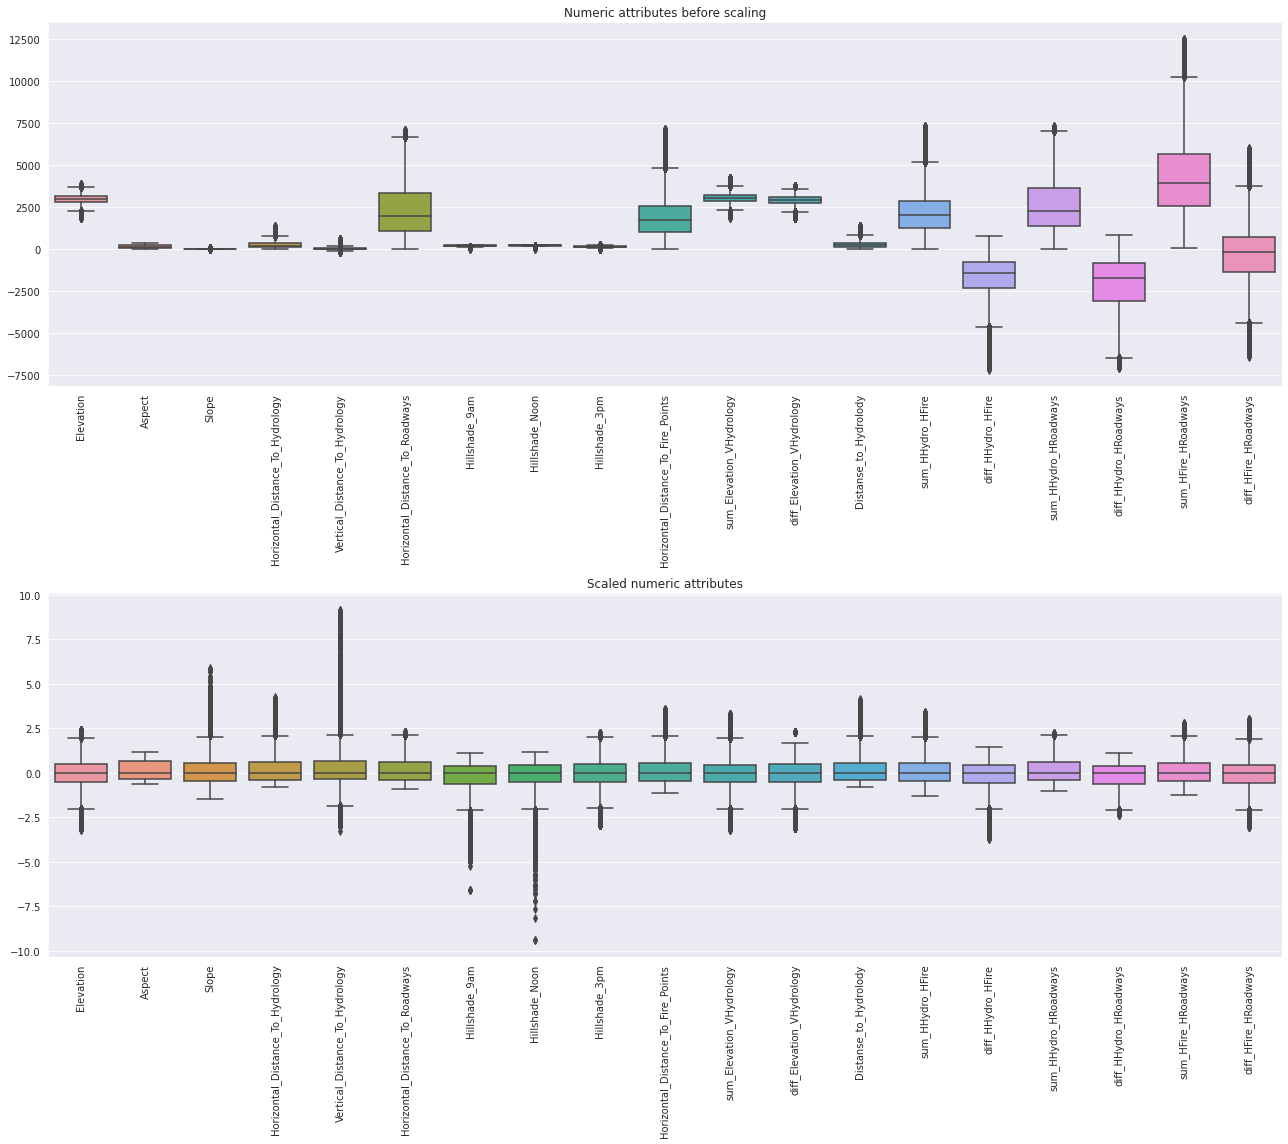

In [25]:
#scale numeric attributes
from sklearn.preprocessing import RobustScaler
def scale_features(data,cols,fit=False):
    global scaler
    # fit the scaler only once on the training data
    if fit:
        scaler = RobustScaler()
        scaler.fit(data[cols])
    scaled_f = scaler.transform(data[cols].values)
    scaled_f = pd.DataFrame(scaled_f, index=data.index, columns=cols)
    data_copy = data.copy()
    scaled_df = data_copy.assign(**scaled_f.to_dict(orient='series'))
    return scaled_df

x_train_scaled = scale_features(x_train,new_num_cols,True)

fig = plt.figure(figsize=(18,2*8))
sns.boxplot( data = x_train[new_num_cols],ax=fig.add_subplot(2,1,1)).set_title('Numeric attributes before scaling')
plt.xticks(rotation=90)
plt.tight_layout()
sns.boxplot( data = x_train_scaled[new_num_cols],ax=fig.add_subplot(2,1,2)).set_title('Scaled numeric attributes')
plt.xticks(rotation=90)
plt.tight_layout()

# Training

## The elt(Elapsed time) function
I have created this function as a decorator to calculate the running time of code blocks.<br>
Since decorators can only be used on functions, code blocks that need timining are wrapped with a dummy function, if they are not in one alread.

In [26]:
def elt(func):
    tic = time()
    func()
    print(f"Time elasped: {time()-tic: .5f} sec")

In [27]:
# performance scores
def score(model,x, y, acc_only=True):
    y_pred = model.predict(x)
    print('\taccuracy: ', end='')
    print(accuracy_score(y, y_pred))
    # classification report and confusion matrix
    if not acc_only:
        print('\tConfusion matrix: ')
        print(confusion_matrix(y, y_pred))
        print('\tClassification report:')
        print(classification_report(y, y_pred))

In [28]:
# train and validate model
def train_model(model, x_train, y_train, x_val, y_val, acc_only=False):
    model.fit(x_train,y_train)
    print('Training')
    score(model, x_train, y_train)
    print('Validation')
    score(model, x_val, y_val, acc_only)

In [29]:
#makes and saves predictions to a csv file with the provided name
def predict_csv(model,name,data = None):
    if data is None:
        data = df_test
    y_pred = model.predict(data)
    # remaping class values to 1-7 [model training was on 0-6]
    y_pred += 1
    test_idx['Cover_Type'] = y_pred
    test_idx.to_csv(f'{name}.csv',index=False)
    

### Training basic models and demonstarting performance gain of adding engineered features
To see how adding derived features imporves performance different models are trained with<br>
the original features and all new features. Performance is evaluated in the validation set.

In [30]:
models = {
     'DecisionTreeClassfier': DecisionTreeClassifier(criterion='entropy', random_state=random_state),
     'ExtraTreesClassifier': ExtraTreesClassifier(criterion='entropy', n_jobs=-1,n_estimators=200, random_state=random_state),
     'RandomForestClassifier': RandomForestClassifier(criterion='entropy', n_jobs=-1,n_estimators=200,random_state=random_state),
     'LogisticRegressionClassifier': LogisticRegression(random_state=random_state)
}
for m in models:
    print('================================================')
    print(f'[Model training] current model: {m}')
    print('================================================')
    @elt
    def dummy():
        print('Using original features only')
        train_model(models[m],x_train_scaled[orig_features],y_train,scale_features(x_val, new_num_cols)[orig_features],y_val, True)
    @elt
    def dummy1():
        print('\n\nOriginal features + engineered features')
        train_model(models[m],x_train_scaled[all_features],y_train,scale_features(x_val, new_num_cols)[all_features],y_val, True)

[Model training] current model: DecisionTreeClassfier
Using original features only
Training
	accuracy: 1.0
Validation
	accuracy: 0.9231822971548999
Time elasped:  6.61677 sec


Original features + engineered features
Training
	accuracy: 1.0
Validation
	accuracy: 0.9389532841587636
Time elasped:  13.02561 sec
[Model training] current model: ExtraTreesClassifier
Using original features only
Training
	accuracy: 1.0
Validation
	accuracy: 0.9420091324200913
Time elasped:  77.74098 sec


Original features + engineered features
Training
	accuracy: 1.0
Validation
	accuracy: 0.9697225149279943
Time elasped:  75.21964 sec
[Model training] current model: RandomForestClassifier
Using original features only
Training
	accuracy: 1.0
Validation
	accuracy: 0.9458728486125746
Time elasped:  85.51435 sec


Original features + engineered features
Training
	accuracy: 1.0
Validation
	accuracy: 0.9689848963821567
Time elasped:  108.39578 sec
[Model training] current model: LogisticRegressionClassifier
Using 

In [31]:
for m in models:
    print('================================================')
    print(f'[Model metrics] current model: {m}')
    print('================================================')
    @elt
    def dummy():
        score(models[m],scale_features(x_val, new_num_cols)[all_features],y_val,False)

[Model metrics] current model: DecisionTreeClassfier
	accuracy: 0.9389532841587636
	Confusion matrix: 
[[ 9875   589     1     0    13     0    55]
 [  566 12985    29     0    58    24    13]
 [    0    47  1656    19     6    65     0]
 [    0     0    11   122     0     8     0]
 [   11    52     5     0   371     5     0]
 [    7    32    60     7     4   802     0]
 [   43     8     0     0     0     0   921]]
	Classification report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     10533
           1       0.95      0.95      0.95     13675
           2       0.94      0.92      0.93      1793
           3       0.82      0.87      0.84       141
           4       0.82      0.84      0.83       444
           5       0.89      0.88      0.88       912
           6       0.93      0.95      0.94       972

    accuracy                           0.94     28470
   macro avg       0.90      0.91      0.90     28470
weighted avg   

In [32]:
#Grid search for best parameters
param_models = {
     'DecisionTreeClassfier': DecisionTreeClassifier(random_state=random_state),
}
for m in param_models:
    print('================================================')
    print(f'[Grid search] current model {m}')
    print('================================================')
    @elt
    def dummy():
        global grid
        parameters = {
            'max_depth': [5, 10, 20,None],
            'min_samples_split': [2, 3, 5],
            'max_features': [10, 20, 40, None],
            'class_weight': [None, 'balanced', 'balanced_subsample'],
            'criterion': ['gini', 'entropy']
        }
        grid = GridSearchCV(param_models[m], parameters, n_jobs=-1, cv=3)
        grid.fit(x_train_scaled[orig_features],y_train)
        print(f'Best score: {grid.best_score_}')
        print(f'Best parameters: {grid.best_params_}')

[Grid search] current model DecisionTreeClassfier
Best score: 0.9076944069839791
Best parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_split': 2}
Time elasped:  445.11224 sec


In [33]:
#boosting decision tree and logistic regression
boosted_models = {
    'BoostedDecisionTreeClassifier': AdaBoostClassifier(DecisionTreeClassifier(criterion='entropy',random_state=random_state),n_estimators=100,random_state=random_state),
    'BoostedLogisticRegressionClassifier': AdaBoostClassifier(LogisticRegression(random_state=random_state),n_estimators=100,random_state=random_state)
}
for m in boosted_models:
    print('================================================')
    print(f'[Boosting ensemble] current model {m}')
    print('================================================')
    @elt
    def dummy():
        train_model(boosted_models[m],x_train_scaled[all_features],y_train,scale_features(x_val, new_num_cols)[all_features],y_val)

[Boosting ensemble] current model BoostedDecisionTreeClassifier
Training
	accuracy: 1.0
Validation
	accuracy: 0.9393045310853531
	Confusion matrix: 
[[ 9872   593     1     0    14     0    53]
 [  558 12993    30     0    55    28    11]
 [    0    49  1663    19     4    58     0]
 [    0     0    11   122     0     8     0]
 [   10    59     7     0   363     5     0]
 [    6    30    60     7     7   802     0]
 [   39     6     0     0     0     0   927]]
	Classification report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     10533
           1       0.95      0.95      0.95     13675
           2       0.94      0.93      0.93      1793
           3       0.82      0.87      0.84       141
           4       0.82      0.82      0.82       444
           5       0.89      0.88      0.88       912
           6       0.94      0.95      0.94       972

    accuracy                           0.94     28470
   macro avg       0.90

In [34]:
#bagging decision tree and logistic regression
bagging_models = {
    'BaggingDecisionTreeClassifier': BaggingClassifier(DecisionTreeClassifier(criterion='entropy',random_state=random_state),n_estimators=30,random_state=random_state),
    'BaggingLogisticRegressionClassifier': BaggingClassifier(LogisticRegression(random_state=random_state),n_estimators=30,random_state=random_state)
}
for m in bagging_models:
    print('================================================')
    print(f'[Bugging ensemble] current model {m}')
    print('================================================')
    @elt
    def dummy():
        train_model(bagging_models[m],x_train_scaled[all_features],y_train,scale_features(x_val, new_num_cols)[all_features],y_val)

[Bugging ensemble] current model BaggingDecisionTreeClassifier
Training
	accuracy: 0.9998751097668065
Validation
	accuracy: 0.9677906568317527
	Confusion matrix: 
[[10187   323     0     0     3     0    20]
 [  275 13344    18     0    20    13     5]
 [    0    24  1733    10     2    24     0]
 [    0     0     7   125     0     9     0]
 [    7    43     4     0   387     3     0]
 [    1    12    52     6     0   841     0]
 [   28     8     0     0     0     0   936]]
	Classification report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     10533
           1       0.97      0.98      0.97     13675
           2       0.96      0.97      0.96      1793
           3       0.89      0.89      0.89       141
           4       0.94      0.87      0.90       444
           5       0.94      0.92      0.93       912
           6       0.97      0.96      0.97       972

    accuracy                           0.97     28470
   macro 

In [35]:
estimators = [
    ('BaggingDecisionTreeClassifier', BaggingClassifier(DecisionTreeClassifier(criterion='entropy',random_state=random_state),
                                                       n_estimators=30,random_state=random_state)),
    ('ExtraTreesClassifier', ExtraTreesClassifier(criterion='entropy', n_jobs=-1,n_estimators=100,random_state=random_state)),
]
stacking = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)
@elt
def dummy():
    train_model(stacking,x_train_scaled[all_features],y_train,scale_features(x_val, new_num_cols)[all_features],y_val)

Training
	accuracy: 1.0
Validation
	accuracy: 0.9715489989462592
	Confusion matrix: 
[[10220   289     0     0     2     0    22]
 [  244 13376    19     0    22     9     5]
 [    0    19  1736     7     4    27     0]
 [    0     0     5   127     0     9     0]
 [    8    33     3     0   397     3     0]
 [    0    11    32     2     1   866     0]
 [   26     8     0     0     0     0   938]]
	Classification report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     10533
           1       0.97      0.98      0.98     13675
           2       0.97      0.97      0.97      1793
           3       0.93      0.90      0.92       141
           4       0.93      0.89      0.91       444
           5       0.95      0.95      0.95       912
           6       0.97      0.97      0.97       972

    accuracy                           0.97     28470
   macro avg       0.96      0.95      0.95     28470
weighted avg       0.97      0.97

## Xgboost classifier
For xgboost classifier conducting a grid search for parameters is better than training it with the default ones or<br>
random tweaking as xgbboost has many parameters that can be tuned.

In [43]:
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier()
parameters = {
     "eta"    : [0.10, 0.20, 0.3],
     "gamma"            : [0.0, 0.1 , 0.4],
}

xgb_grid = GridSearchCV(xgb,
                    parameters, n_jobs=-1,
                    scoring="neg_log_loss",
                    cv=3,
                    verbose=2)
@elt
def dummy():
    xgb_grid.fit(x_train[all_features][:100000], y_train[:100000])
    print(f'Best score: {xgb_grid.best_score_}')
    print(f'Best parameters: {xgb_grid.best_params_}')

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 15.8min finished


Best score: -0.574464317195264
Best parameters: {'eta': 0.1, 'gamma': 0.4}
Time elasped:  1086.62208 sec


In [49]:
from xgboost import XGBClassifier
xgb = XGBClassifier(eta=0.2,gamma=0.1,max_depth=20,n_estimators=200)
@elt
def dummy():
    print('================================================')
    print(f'[Model training] current model: xgboost')
    print('================================================')
    x_train_val_scaled = scale_features(x_train_val,new_num_cols,True)
    train_model(xgb,x_train_val_scaled[all_features],y_train_val,scale_features(x_test, new_num_cols)[all_features],y_test)
    x_train_scaled = scale_features(x_train,new_num_cols,True)

[Model training] current model: xgboost
Training
	accuracy: 1.0
Validation
	accuracy: 0.9741420996123364
	Confusion matrix: 
[[43123  1155     1     0    16     2    77]
 [  844 58626    68     2    93    44    10]
 [    0    69  7392    27     7    99     0]
 [    0     0    43   504     0    24     0]
 [   21   174    13     0  1736     3     0]
 [    2    60   125    13     2  3398     0]
 [  142    18     0     0     1     0  4079]]
	Classification report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     44374
           1       0.98      0.98      0.98     59687
           2       0.97      0.97      0.97      7594
           3       0.92      0.88      0.90       571
           4       0.94      0.89      0.91      1947
           5       0.95      0.94      0.95      3600
           6       0.98      0.96      0.97      4240

    accuracy                           0.97    122013
   macro avg       0.96      0.94      0.95    

## Deep Neural Network (DNN)
The main challenge with training DNNs is having too many parameters to tune, network<br>
structure and learning rate being the most important ones, and overfitting.<br>
It is common practice to use powers of two for number of neurons in a layer.

In [39]:
mlp = MLPClassifier(hidden_layer_sizes=(64,128,64,32), random_state=random_state, validation_fraction=0.1, max_iter=300,verbose=True)
@elt
def dummy():
    print('================================================')
    print(f'[Model training] current model: Multi layer perceptron')
    print('================================================')
    train_model(mlp,x_train_scaled[all_features],y_train,scale_features(x_val, new_num_cols)[all_features],y_val)

[Model training] current model: Multi layer perceptron
Iteration 1, loss = 0.57673514
Iteration 2, loss = 0.44302030
Iteration 3, loss = 0.39788107
Iteration 4, loss = 0.36818192
Iteration 5, loss = 0.34646995
Iteration 6, loss = 0.32939122
Iteration 7, loss = 0.31486264
Iteration 8, loss = 0.30409276
Iteration 9, loss = 0.29285543
Iteration 10, loss = 0.28387616
Iteration 11, loss = 0.27664833
Iteration 12, loss = 0.26887700
Iteration 13, loss = 0.26199575
Iteration 14, loss = 0.25682364
Iteration 15, loss = 0.25126467
Iteration 16, loss = 0.24684406
Iteration 17, loss = 0.24094243
Iteration 18, loss = 0.23668416
Iteration 19, loss = 0.23214562
Iteration 20, loss = 0.22893987
Iteration 21, loss = 0.22464069
Iteration 22, loss = 0.22092448
Iteration 23, loss = 0.21873805
Iteration 24, loss = 0.21464142
Iteration 25, loss = 0.21321992
Iteration 26, loss = 0.20926401
Iteration 27, loss = 0.20670912
Iteration 28, loss = 0.20471820
Iteration 29, loss = 0.20137177
Iteration 30, loss = 0.199

## Performance and prediction

In [36]:
for m_dict in [models,boosted_models,bagging_models]:
    for m in m_dict:
        print(m + ' ',end='')
        score(m_dict[m],scale_features(x_test, new_num_cols)[all_features],y_test)
        @elt
        def dummy():
            predict_csv(m_dict[m],m,scale_features(df_test, new_num_cols)[all_features])

DecisionTreeClassfier 	accuracy: 0.9377607304139722
Time elasped:  1.63376 sec
ExtraTreesClassifier 	accuracy: 0.9702408759722325
Time elasped:  7.40080 sec
RandomForestClassifier 	accuracy: 0.9692327866702728
Time elasped:  5.17071 sec
LogisticRegressionClassifier 	accuracy: 0.7261521313302681
Time elasped:  0.64746 sec
BoostedDecisionTreeClassifier 	accuracy: 0.9381869145091097
Time elasped:  0.75477 sec
BoostedLogisticRegressionClassifier 	accuracy: 0.49252948456312035
Time elasped:  11.72751 sec
BaggingDecisionTreeClassifier 	accuracy: 0.9673477416340882
Time elasped:  3.42471 sec
BaggingLogisticRegressionClassifier 	accuracy: 0.726529140337505
Time elasped:  3.31734 sec


In [37]:
print('Stacking ',end='')
score(stacking,scale_features(x_test, new_num_cols)[all_features],y_test)
@elt
def dummy():
    predict_csv(stacking, 'Stacking_bdt_etc', scale_features(df_test, new_num_cols)[all_features])

Stacking 	accuracy: 0.9713637071459599
Time elasped:  7.00918 sec


In [50]:
print('Xgboost ',end='')
score(xgb,scale_features(x_test, new_num_cols)[all_features],y_test)
@elt
def dummy():
    x_train_val_scaled = scale_features(x_train_val,new_num_cols,True)
    predict_csv(xgb,'Xgboost',scale_features(df_test, new_num_cols)[all_features])
    x_train_scaled = scale_features(x_train,new_num_cols,True)

Xgboost 	accuracy: 0.9738388532369502
Time elasped:  77.59229 sec


In [40]:
print('MLP ',end='')
score(mlp,scale_features(x_test, new_num_cols)[all_features],y_test)
@elt
def dummy():
    predict_csv(mlp,'mlp', scale_features(df_test, new_num_cols)[all_features])

MLP 	accuracy: 0.9355232639145009
Time elasped:  3.77422 sec
